<a href="https://colab.research.google.com/github/e-viola/Data_Science_R_Studio/blob/main/Learn_Model_Building_IDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/cognitedata/interacting-with-open-industrial-data/blob/master/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Visualization and Time series prediction

## What this notebook will achieve

* Extract live data from an oil rig in the North Sea.

* Visualize and inspect data directly from Cognite Data Fusion.

* Apply and assess several machine learning models for time series prediction.


## Getting started

* Having a basic understanding of Python concepts will help to understand the process.

* Cognite has released *live* data to the public on Cognite Data Fusion (CDF) streaming from [Valhall](https://www.akerbp.com/en/our-assets/production/valhall/), one of Aker's oil fields.

* To access the data, generate an API Key on [Open Industrial Data](https://openindustrialdata.com/). Get your key via the Google Access platform. You will be asked to fill out some personal information to generate your personal key.

* Visualize some of the machines (assets) on Valhall with Cognite's [Operational Intelligence](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) dashboard. This data on this page shows is streaming live data from the Valhall oil field located in the North Sea.

* To understand how to interact with the data using the Python SDK ([Docs](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/)) follow along in this notebook.

ModuleNotFoundError: ignored

## Environment Setup

#### Install the Cognite SDK package

In [ ]:
!pip install cognite-sdk
!pip install --upgrade numpy
!pip install --upgrade scikit-learn
!pip install msal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Import the required packages

In [ ]:
%matplotlib inline

import os
from datetime import datetime, timedelta
from datetime import datetime
from getpass import getpass


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# from sklearn.slm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# low variance data feature
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# added as part of the correlation calculations
import seaborn as sns
import scipy.stats as stats

# Normalize the data
from sklearn import preprocessing

#
from sklearn.model_selection import train_test_split


from random import seed
seed(1234)

AttributeError: ignored

#### Connect to Cognite Data Fusion


In [ ]:
# Import the Cognite Client
from cognite.client import CogniteClient, ClientConfig
from cognite.client.credentials import Token
from msal import PublicClientApplication

# Contact Project Administrator to get these
TENANT_ID = '48d5043c-cf70-4c49-881c-c638f5796997'
CLIENT_ID = '1b90ede3-271e-401b-81a0-a4d52bea3273'
CDF_CLUSTER = "api"  # api, westeurope-1 etc
COGNITE_PROJECT = "publicdata"

BASE_URL = f"https://{CDF_CLUSTER}.cognitedata.com"
SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID

app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)


def authenticate_device_code(app):
    # Firstly, check the cache to see if this end user has signed in before
    accounts = app.get_accounts()
    if accounts:
        creds = app.acquire_token_silent(SCOPES, account=accounts[0])
    else:
        device_flow = app.initiate_device_flow(scopes=SCOPES)
        print(device_flow["message"])  # print device code to screen
        creds = app.acquire_token_by_device_flow(flow=device_flow)
    return creds


def get_token():
    return authenticate_device_code(app)["access_token"]

cnf = ClientConfig(client_name="my-special-client", project=COGNITE_PROJECT, credentials=Token(get_token), base_url=BASE_URL)
client = CogniteClient(cnf)

print(client.iam.token.inspect())

## Accessing Cognite Data Fusion (CDF)
* CDF organizes digital information about the physical world.
* There are 6 kinds of objects stored on CDF. Each of these objects in CDF are labelled with a unique ID. Information regarding a specific Asset, Event, etc are often retrieved using this ID.

  * [Assets](https://doc.cognitedata.com/api/0.5/#tag/Assets) are digital representations of physical objects or groups of objects, and assets are organized into an asset hierarchy. For example, an asset can represent a water pump which is part of a subsystem on an oil platform.

  * [Event](https://doc.cognitedata.com/api/0.5/#tag/Events) objects store complex information about multiple assets over a time period. For example, an event can describe two hours of maintenance on a water pump and some associated pipes.

  * A [File](https://doc.cognitedata.com/api/0.5/#tag/Files) stores a sequence of bytes connected to one or more assets. For example, a file can contain a piping and instrumentation diagram (P&IDs) showing how multiple assets are connected.

  * A [Time Series](https://doc.cognitedata.com/api/0.5/#tag/Time-series) consists of a sequence of data points connected to a single asset. For example: A water pump asset can have a temperature time series that records a data point in units of °C every second.

  * [Sequence](https://doc.cognitedata.com/api/0.5/#tag/Sequences) are similar to time series in that they are a key value pair, but rather than using a timestamp as the key, another measurment such as depth could be the key. For example, this is used in practice when drilling and taking measurments at various depths.

  * A [3D](https://doc.cognitedata.com/api/0.5/#tag/3D) model is typically built up by a hierarchical structure. This looks very similar to how we organize our internal asset hierarchy. 3D models are visualized via Cognite's dashboards.

* It is important to refer back to the [SDK](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html) for specific details on arguments on all avaiable methods on how to access these objects.

# Part i
## Soft sensor

Imagine you are an engineer in charge of operating a gas compressor. Unfortunately, the output pressure sensor has broken, and we wish to be able to predict what it is in lieu of a live reading. To this end, we will use the flow rate, temperature, and suction pressure to try and predict the input pressure. By training the algorithms on a period in which we had the data from the missing sensor, we can create a model to be able to predict it in the future.

#### Collect datapoints from CDF

* The following data will form the input and output of our model:

* Input variables:

  * FT: Input Flow Rate, m3/hr

  * PT: Input Pressure, bar

  * TT: Input Temperature, degC

* Output variables:

  * Output Pressure, bar

The time series names are defined in the *in_ts_names* and *out_ts_names* lists below.


In [ ]:
in_ts_name = ["pi:160192", "pi:160702", "pi:191092"]
out_ts_name = "pi:160700"

#### Retrieve Data Points from CDF

We start by retrieving a month of data to train out model on. In this dataframe we have both input data, and the target our model will predict.

In [ ]:
ts_names = in_ts_name + [out_ts_name]

train_start_date = datetime(2018, 8, 1)
# 30 days of training data chosen arbitrarily
train_end_date = train_start_date + timedelta(days=30)

datapoints_df = client.datapoints.retrieve_dataframe(
    external_id=ts_names,
    start=train_start_date,
    end=train_end_date,
    aggregates=["average"],
    granularity="1m",
)
datapoints_df.fillna(method="ffill", inplace=True)
datapoints_df.rename(columns=lambda x: x[:-8] if x != "timestamp" else x, inplace=True)
datapoints_df.head()

/usr/local/lib/python3.10/dist-packages/cognite/client/utils/_time.py:14: FutureWarning: Interpreting given naive datetime as UTC instead of local time (against Python default behaviour). This will change in the next major release (4.0.0). Please use (timezone) aware datetimes or convert it yourself to integer (number of milliseconds since epoch, leap seconds excluded).
  warnings.warn(


,pi:160192,pi:160702,pi:191092,pi:160700
2018-08-01 00:00:00,18.559723,12.506796,35.305566,2.687534
2018-08-01 00:01:00,18.566998,12.376762,35.206751,2.696253
2018-08-01 00:02:00,18.566593,12.590231,35.116018,2.741832
2018-08-01 00:03:00,18.557141,12.654518,34.797634,2.713912
2018-08-01 00:04:00,18.539114,12.831217,34.612878,2.766648


In [ ]:
# Check for missing data after forward filling NAs
datapoints_df.isna().any()

pi:160192    False
pi:160702    False
pi:191092    False
pi:160700    False
dtype: bool

#### Visualize the Time Series data
We utilize matplotlib to visualize each of the time series plots, the bottom right plot is the output time series, while the other 3 are the inputs used to create an estimate for the output.
#### We see that the sensor corresponding to pi:16702 seems to fail around 25-08-2018. We will come back to this later.


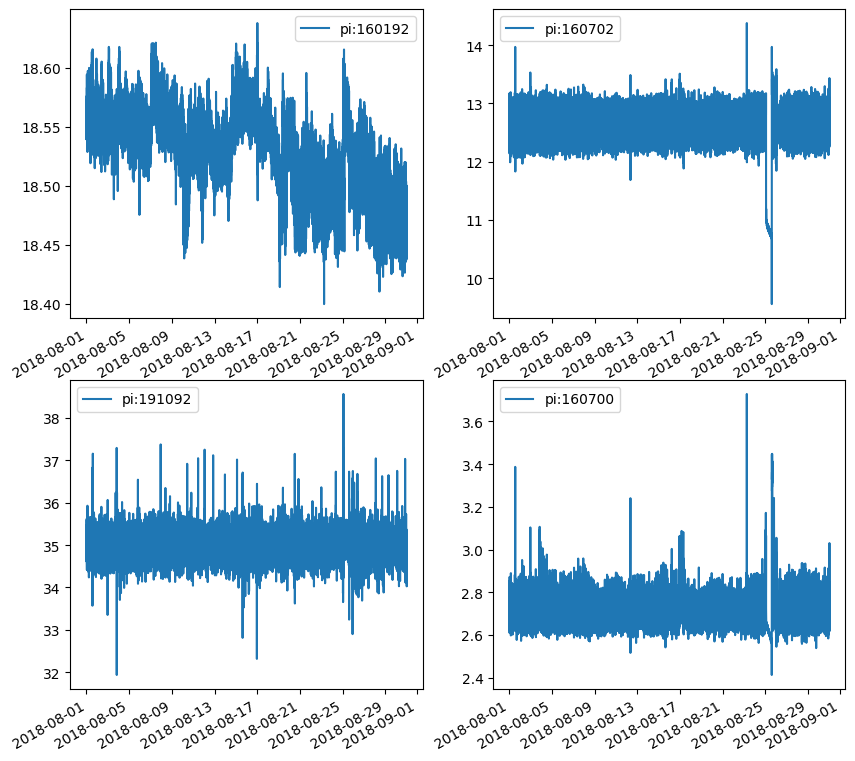

In [ ]:
cols = [col for col in datapoints_df if col != "timestamp"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, col in enumerate(cols):
    datapoints_df.loc[:, [col]].plot(ax=axes[int(i > 1), i % 2])

### Gather the training data using the data from the figures above

In [ ]:
train_X = datapoints_df[in_ts_name].values
train_y = datapoints_df[out_ts_name].values

### Get a seperate DataFrame from CDF for predictions

* Now that we have the data we want to train our model on, we retrieve another dataset to test on after the training period. This will show how the model performs on data it hasn't seen before, which is important since we want a model which can reliably calculate the output pressure in the future.

In [ ]:
predict_start_date = train_end_date
# Make the prediction on 1 hour of data
predict_end_date = train_end_date + timedelta(hours=1)

predict_df = client.datapoints.retrieve_dataframe(
    external_id=ts_names,
    aggregates=["average"],
    granularity="1m",
    start=predict_start_date,
    end=predict_end_date,
)
predict_df.fillna(method="ffill", inplace=True)
predict_df.rename(columns=lambda x: x[:-8] if x != "timestamp" else x, inplace=True)
predict_df.head()

/usr/local/lib/python3.10/dist-packages/cognite/client/utils/_time.py:14: FutureWarning: Interpreting given naive datetime as UTC instead of local time (against Python default behaviour). This will change in the next major release (4.0.0). Please use (timezone) aware datetimes or convert it yourself to integer (number of milliseconds since epoch, leap seconds excluded).
  warnings.warn(


,pi:160192,pi:160702,pi:191092,pi:160700
2018-08-31 00:00:00,18.498291,12.628815,35.163508,2.715669
2018-08-31 00:01:00,18.467523,12.576537,35.022325,2.701946
2018-08-31 00:02:00,18.469492,12.768185,34.939366,2.793748
2018-08-31 00:03:00,18.486298,12.839084,35.076077,2.772871
2018-08-31 00:04:00,18.487308,12.770062,35.246254,2.716691


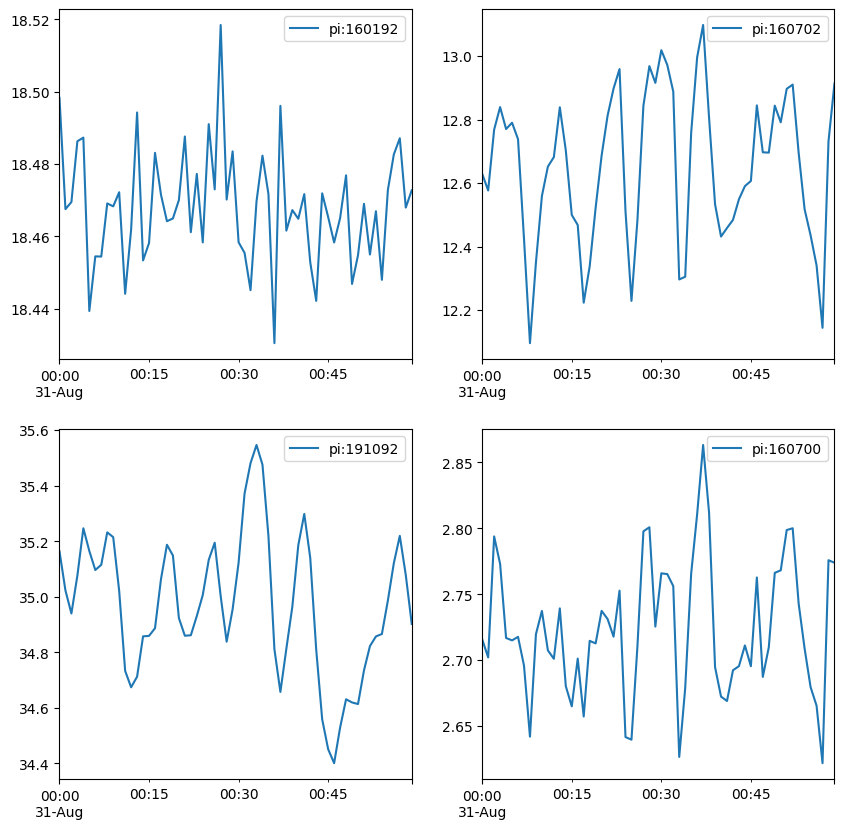

In [ ]:
cols = [col for col in predict_df.columns if col != "timestamp"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for i, col in enumerate(cols):
    predict_df.loc[:, [col]].plot(ax=axes[int(i > 1), i % 2])

## Linear Regression Model

* As a simple starting point we will check to see how a linear regression model performs to predict the output pressure
* A linear regression model fits a linear map *y = a*x1 + b*x2 + c*x3 + ... to the data, by minimising the square of the difference between the predicted values and real values using *stochastic gradient descent*

### Utilize *sklearn*  to create a basic linear regression model

* Sklearn is common package utilized to import and deploy data science models. Linear Regression is only 1 of many options for constructing models.

The Mean Squared Error of our forecasts is 0.0011
The R2 score of our forecasts is 0.575


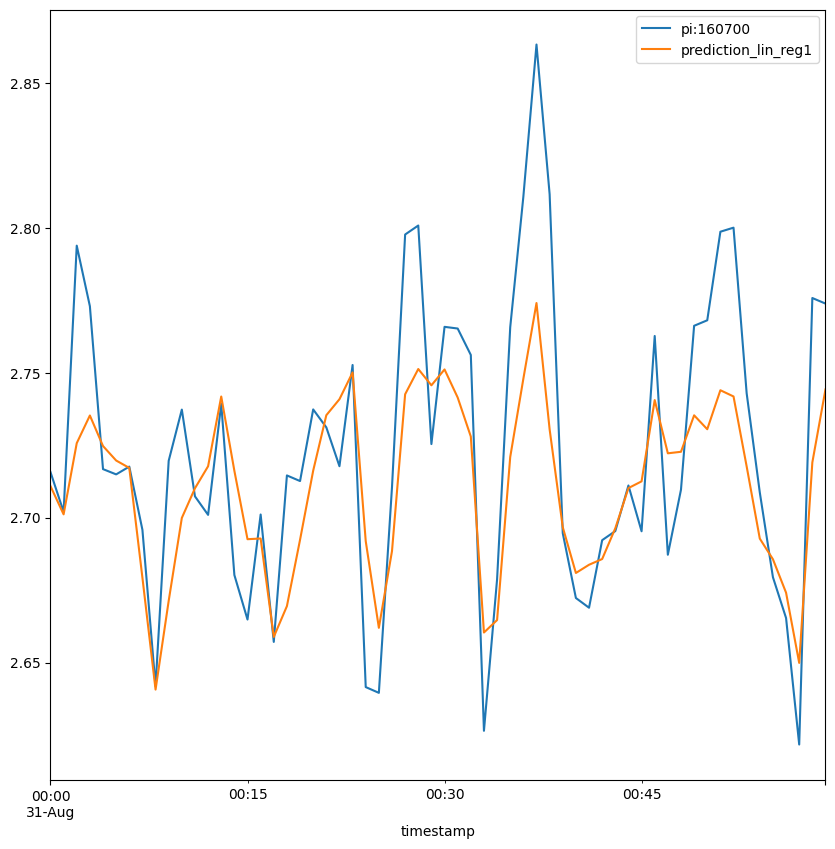

In [ ]:
%matplotlib inline

# create the linear regression model and fit it on our training data
lin_reg1 = LinearRegression()
lin_reg1.fit(train_X, train_y)

# test the linear model on out test data
X = predict_df[in_ts_name].values
predict_df["prediction_lin_reg1"] = lin_reg1.predict(X)
predict_df["timestamp"] = predict_df.index

# print out results of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_lin_reg1"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_lin_reg1"])
print("The Mean Squared Error of our forecasts is {}".format(round(mse, 4)))
print("The R2 score of our forecasts is {}".format(round(r2_s, 4)))

# plot the predicted data alongside the real data
predict_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg1"], figsize=(10, 10))
plt.show()

### Look at the fit for the training data

The Mean Squared Error on the training data is 0.0026
The R2 score of our training data is 0.3842


<Axes: >

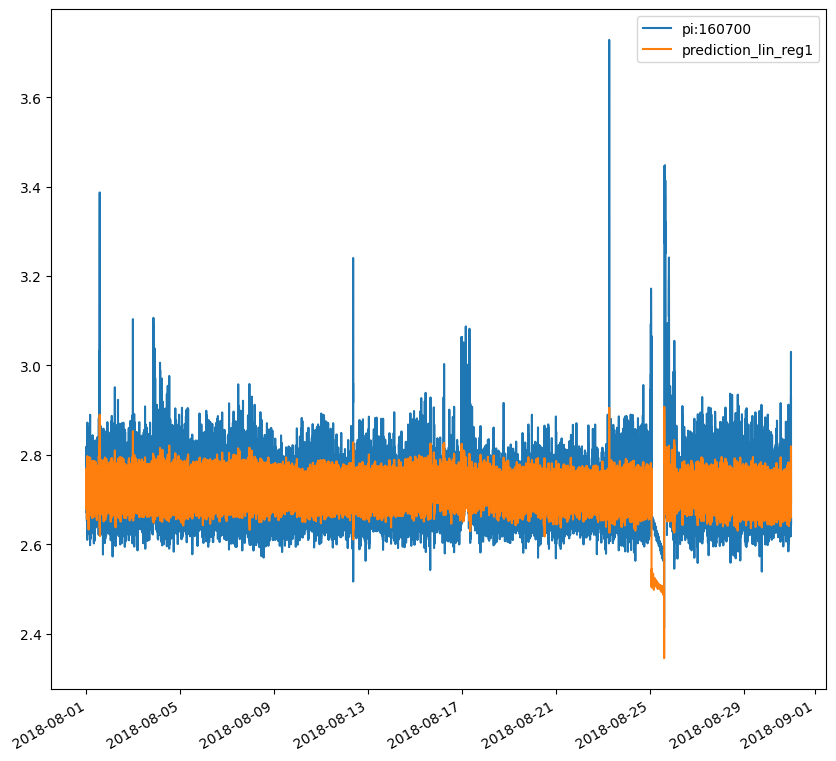

In [ ]:
# perform the same process but see how the model performed on the training data
X = datapoints_df[in_ts_name].values
datapoints_df["prediction_lin_reg1"] = lin_reg1.predict(X)

# print out mse of the prediction
mse = mean_squared_error(
    datapoints_df[out_ts_name], datapoints_df["prediction_lin_reg1"]
)
r2_s = r2_score(datapoints_df[out_ts_name], datapoints_df["prediction_lin_reg1"])
print("The Mean Squared Error on the training data is {}".format(round(mse, 4)))
print("The R2 score of our training data is {}".format(round(r2_s, 4)))

datapoints_df.plot(y=[out_ts_name, "prediction_lin_reg1"], figsize=(10, 10))

### Results

* As seen in the above, the Linear Regression model is struggling on to the anomalous period, and is also struggling in extreme values in the target.

* Linear regression assumes a linear relationship between input parameters, an assumption which may not hold during this anomalous period.

### 2. Remove outliers
* Recall from our plot of the feature space that the sensor corresponding to *pi:160702* drops erroneously. We apply a heuristic filter in an attempt to clean our training data set
* From the histogram of values for *pi:160702* below, set the variable *thresh* as a cutoff for what we consider normal values

<Axes: >

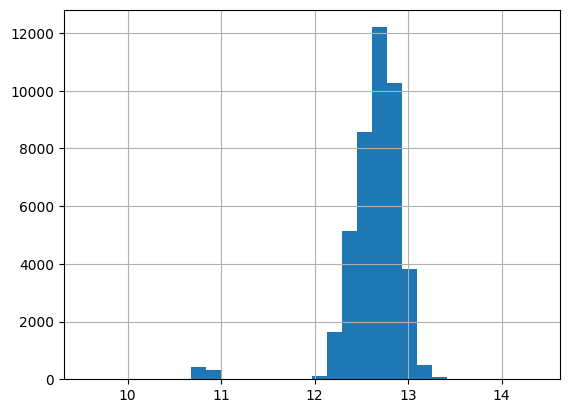

In [ ]:
datapoints_df["pi:160702"].hist(bins=30)

In [ ]:
# Set variable thresh here:
thresh = 11.5

In [ ]:
datapoints_df_adj = datapoints_df[datapoints_df["pi:160702"] > thresh]

In [ ]:
train_X_adj = datapoints_df_adj[in_ts_name].values
train_y_adj = datapoints_df_adj[out_ts_name].values

The Mean Squared Error of our forecasts is 0.001
The R2 score of our forecasts is 0.6114


<Axes: xlabel='timestamp'>

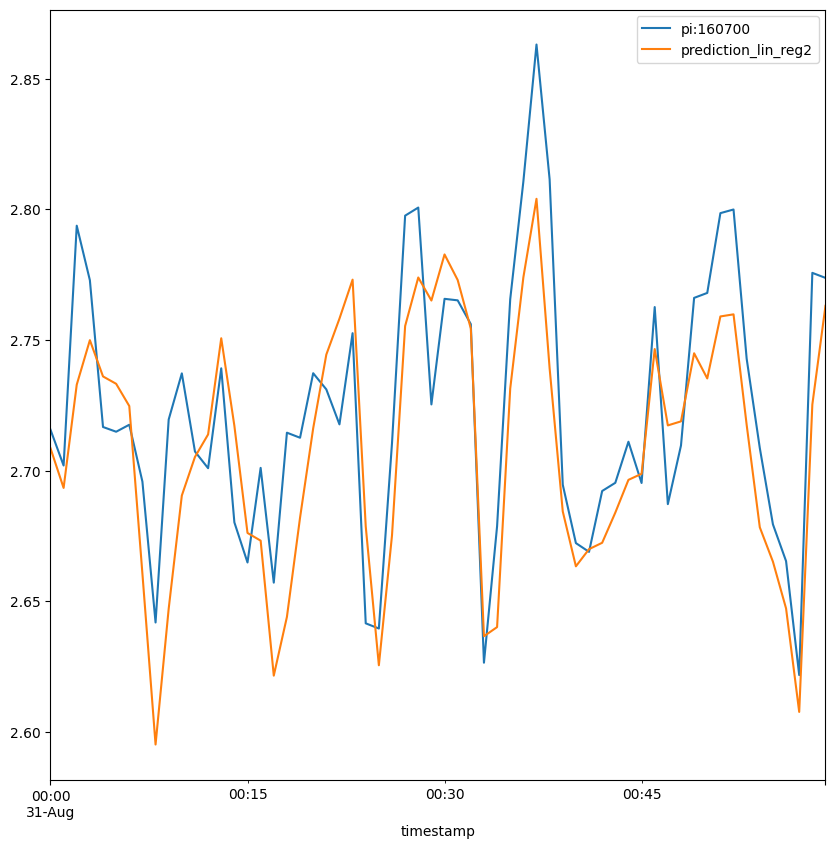

In [ ]:
lin_reg_adj = LinearRegression()
lin_reg_adj.fit(train_X_adj, train_y_adj)

X = predict_df[in_ts_name].values
predict_df["prediction_lin_reg2"] = lin_reg_adj.predict(X)

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_lin_reg2"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_lin_reg2"])
print("The Mean Squared Error of our forecasts is {}".format(round(mse, 4)))
print("The R2 score of our forecasts is {}".format(round(r2_s, 4)))

predict_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg2"], figsize=(10, 10))

### Look at the fit for the training data

<ipython-input-20-12b8f1eadbaa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datapoints_df_adj["prediction_lin_reg2"] = lin_reg_adj.predict(X)


The Mean Squared Error on the training data is 0.0021
The R2 score of our training data is 0.4821


<Axes: >

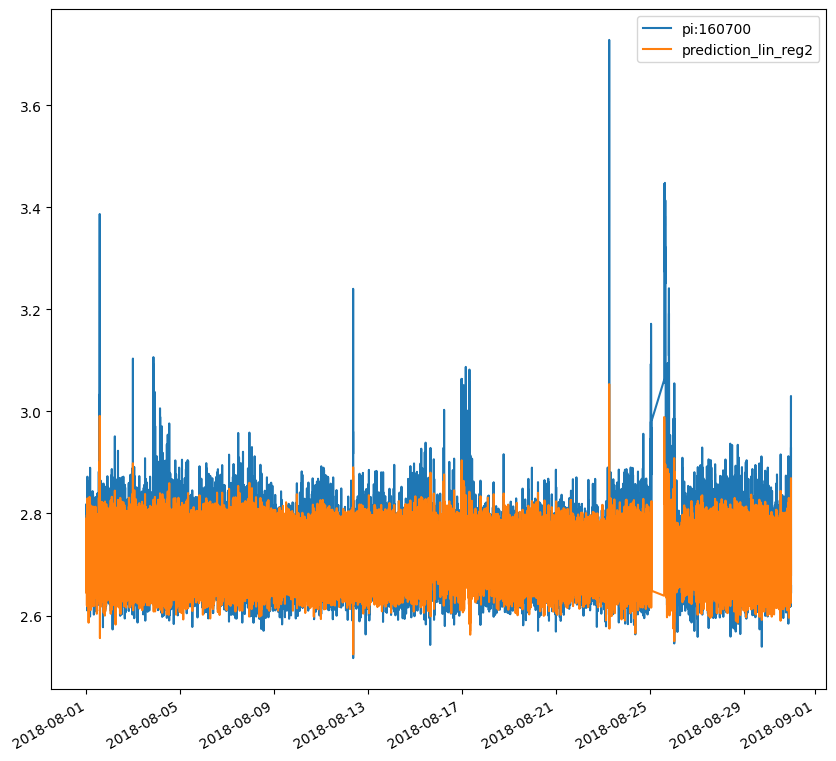

In [ ]:
X = datapoints_df_adj[in_ts_name].values
datapoints_df_adj["prediction_lin_reg2"] = lin_reg_adj.predict(X)

# print out mse of the prediction
mse = mean_squared_error(
    datapoints_df_adj[out_ts_name], datapoints_df_adj["prediction_lin_reg2"]
)
r2_s = r2_score(
    datapoints_df_adj[out_ts_name], datapoints_df_adj["prediction_lin_reg2"]
)
print("The Mean Squared Error on the training data is {}".format(round(mse, 4)))
print("The R2 score of our training data is {}".format(round(r2_s, 4)))

datapoints_df_adj.plot(y=[out_ts_name, "prediction_lin_reg2"], figsize=(10, 10))

### Results
* The original model predicts the normal period well, but we increase accuracy significantly by cleaning up our training data set.
* In general, parametric methods are most suited for simple problems.

### Remarks:
* Linear regression is a parametric model.
* Parametric models are simple, they are easy to understand and the results are interpretable. They are fast to train and you don't need a lot of data to train them.
* However,  by choosing a functional form these methods are constrained to the specified form, which can result in poor fit if the assumptions are not satisfied. Parametric models are are more suited for simpler problems.
* For this use-case a non-parametric model can result in a better fit.
* Further discussion with a subject matter expert is important help to verify the pathology removed in our cleaning process, and if this could affect future predictions.

## Random Forest Model
* Try an alternative model to predict the pressure output
* Random forest is a tree based learning method, using a large number of decision trees to predict a result.
* A single decision tree may overfit to learn the training data quite explicitly, so by modelling a huge number of shallow trees we try to minimise this chance.

The Mean Squared Error of our forecasts is 0.0009
The R2 score of our forecasts is 0.6436


<Axes: xlabel='timestamp'>

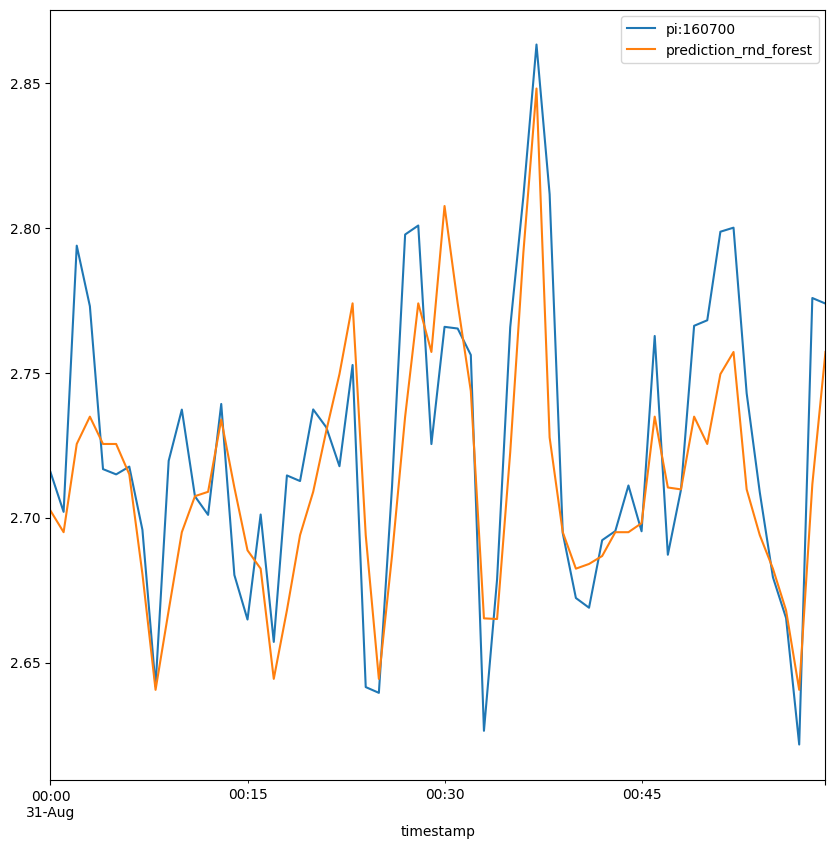

In [ ]:
rnd_forest_reg = RandomForestRegressor(
    n_estimators=10, min_samples_split=20, max_depth=5, random_state=1234
)
rnd_forest_reg.fit(train_X, train_y)

X = predict_df[in_ts_name].values
predict_df["prediction_rnd_forest"] = rnd_forest_reg.predict(X)

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_rnd_forest"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_rnd_forest"])
print("The Mean Squared Error of our forecasts is {}".format(round(mse, 4)))
print("The R2 score of our forecasts is {}".format(round(r2_s, 4)))

predict_df.plot(
    x="timestamp", y=[out_ts_name, "prediction_rnd_forest"], figsize=(10, 10)
)

<Axes: >

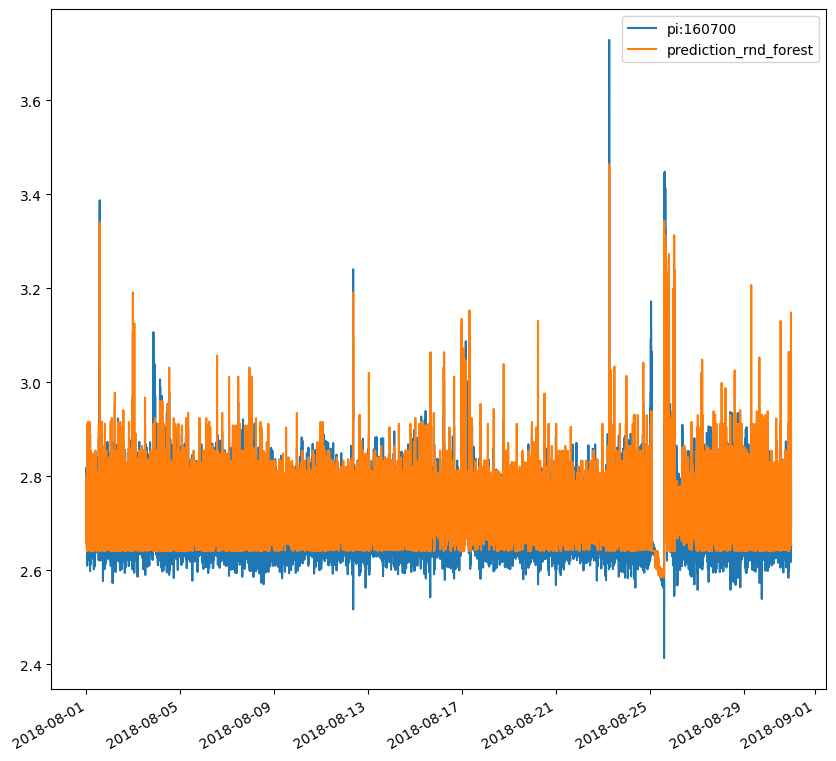

In [ ]:
rnd_forest_reg = RandomForestRegressor(
    n_estimators=10, min_samples_split=20, max_depth=5, random_state=1234
)
rnd_forest_reg.fit(train_X, train_y)

X = datapoints_df[in_ts_name].values
datapoints_df["prediction_rnd_forest"] = rnd_forest_reg.predict(X)

datapoints_df.plot(y=[out_ts_name, "prediction_rnd_forest"], figsize=(10, 10))

### Outlier removal
* For a fair comparison we train the random forest model on the cleaned data set as well.
* We use the exact same dataset as previously

The Mean Squared Error of our forecasts is 0.001
The R2 score of our forecasts is 0.6305


<Axes: xlabel='timestamp'>

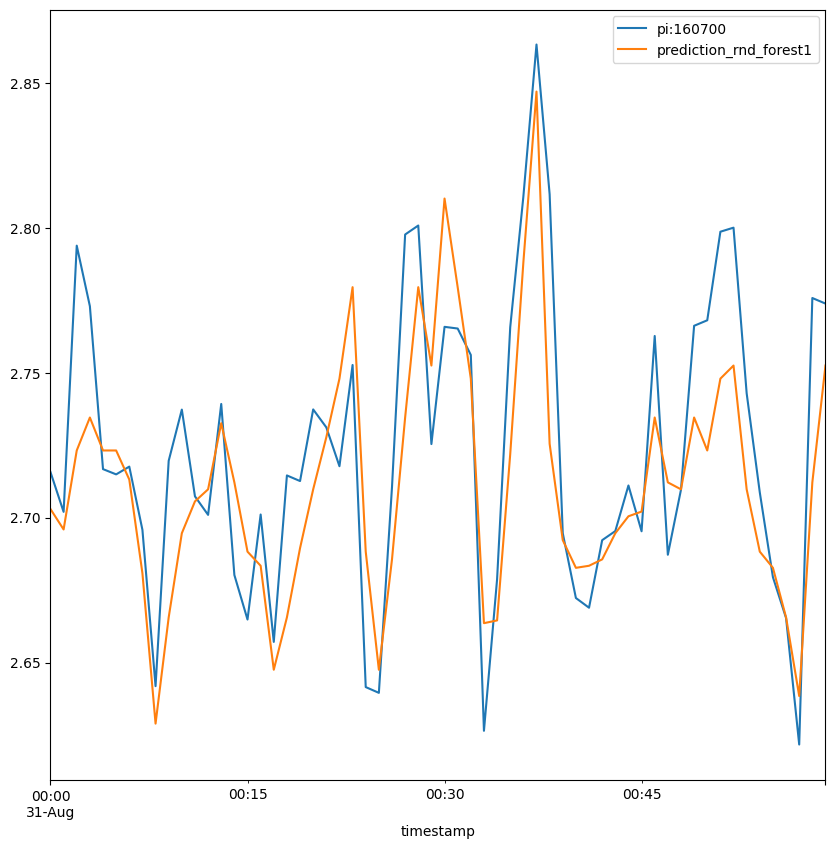

In [ ]:
rnd_forest_reg1 = RandomForestRegressor(
    n_estimators=10, min_samples_split=20, max_depth=5, random_state=1234
)
rnd_forest_reg1.fit(train_X_adj, train_y_adj)

X = predict_df[in_ts_name].values
predict_df["prediction_rnd_forest1"] = rnd_forest_reg1.predict(X)

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_rnd_forest1"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_rnd_forest1"])
print("The Mean Squared Error of our forecasts is {}".format(round(mse, 4)))
print("The R2 score of our forecasts is {}".format(round(r2_s, 4)))

predict_df.plot(
    x="timestamp", y=[out_ts_name, "prediction_rnd_forest1"], figsize=(10, 10)
)

## Results:
* Remarkably, the random forest *decreases* in performance upon removal of outliers, although not significantly enough to say that it is a better approach in general. Since the random forest algorithm is non-parametric, and thus doesn't make assumptions about the form of the data such as linearity, it is able to use the anomalous period of data as useful input when constructing the model.
* The random forest model slightly better than our linear regressor on the cleaned data set, but much better on the uncleaned data set. In this sense the random forest algorithm can be considered better "out of the box," that is, without as much data scientist input/data cleaning.


# Examining model behaviour:
* To understand why a model performs in a certain way, and to give the model something more in the way of explainability, we can examine the *feature importance* of the model.
* This tells us how much consideration the final model gives to each of the input features.
* We will proceed in slightly different ways for the two different types of models.

### Linear model
Since our linear regression model is parametric, we can extract the parameters, namely the coefficients for the different features. As normal in a linear map, a higher amplitude of coefficient means the model is more "sensitive" to changes in that feature.

In [ ]:
print("Input features: ", in_ts_name)
print("Linear model coefficients: ", lin_reg_adj.coef_)

Input features:  ['pi:160192', 'pi:160702', 'pi:191092']
Linear model coefficients:  [0.1423041  0.20510208 0.00075896]


We see that the first two time series are relatively important, whilst the latter is rather unimportant.

### Random Forest
Since our random forest model is non-parametric, the most popular feature importance measures are a little less explainable. The method built into scikit is an *impurity based feature importance*, which takes into account how the feature is used in the decision trees, both in terms of depth within the individual trees and the error in constructing them.

In [ ]:
print("Input features: ", in_ts_name)
print("Random forest model coefficients: ", rnd_forest_reg.feature_importances_)

Input features:  ['pi:160192', 'pi:160702', 'pi:191092']
Random forest model coefficients:  [0.02175694 0.96531326 0.0129298 ]


We see that the random forest model is heavily weighted towards the *pi:160702* feature. It should be noted that since these importances have been normalised it is not so udeful to compare the values between models, but rather the relative positions of the individual features.

One drawback of this feature importance method is that because it based on the decision trees built on the training data set, it may not represent how the features affect the model's performance on the test set, which can be misleading for an especially overfitted model.

To mitigate this potential shortcoming, we can also use a permutation importance. This method essentially shuffles the values for each feature one at a time, so that they have the same overall distribution but no longer have the correct correrspondence to their real timestamps. Those features whose permutated versions lead to a higher drop in model performance on the test set are deemed to have higher importance.

In [ ]:
from sklearn.inspection import permutation_importance

X = predict_df[in_ts_name].values
y = predict_df[out_ts_name].values
perm_feature_importance = permutation_importance(
    rnd_forest_reg, X, y, n_repeats=10, random_state=42, n_jobs=2
)

print("Permutation feature importances", perm_feature_importance["importances_mean"])

Permutation feature importances [ 3.98869546e-05  1.31378003e+00 -1.04883680e-03]


We see that on the test set the only feature with significant importance is *pi:160702*.

A keen observer may notice that if two features are highly correlated, they will score comparitively lower in feature importance based on permutaions, since the corresponding feature can be used by the model in a similar fashion. Here we see two features with next to no significance using this method. Do you think this could be due to a correlation? What else could cause this relative drop?

# Part ii
## Anomaly detection

Imagine now that we have all four sensors in operation and giving reasonable data. We now wish to construct a very basic anomaly detection model. After discussing with an SME, you find out that the variables should be linearly related. On this basis, you come up with the idea to train a linear model on normal data, and use the error between this model and future data to decide whether a period is anomalous or not.

We start by retrieving training data up until just before the anomalous period we encountered in the previous section:

In [ ]:
# Train the model up until 100 timestamps before anomalous period
predict_start_index = min(np.where(datapoints_df["pi:160702"] < 11.2)[0]) - 100

In [ ]:
datapoints_df_ad = datapoints_df.iloc[:predict_start_index, :]
train_X = datapoints_df_ad[in_ts_name].values
train_y = datapoints_df_ad[out_ts_name].values

predict_df_ad = datapoints_df[ts_names].iloc[predict_start_index:, :]

Text(0.5, 1.0, 'pi:160700')

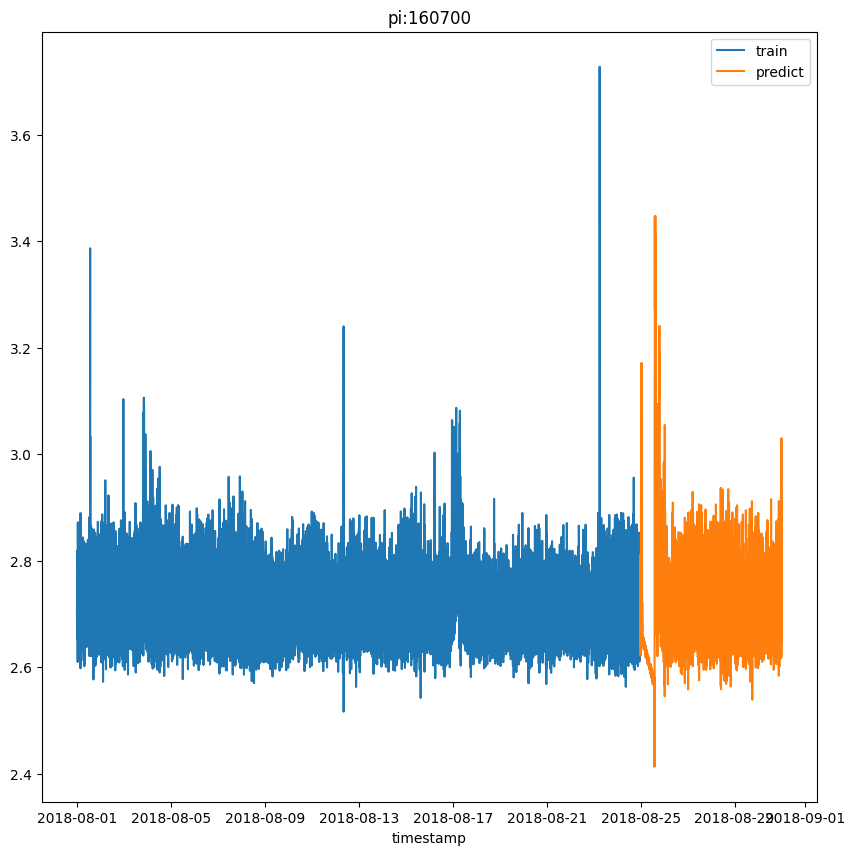

In [ ]:
# We have a look at one of the time series to show which periods we will train and test on
plt.figure(figsize=(10, 10))
plt.plot(datapoints_df_ad[out_ts_name], label="train")
plt.plot(predict_df_ad[out_ts_name], label="predict")
plt.legend()
plt.xlabel("timestamp")

plt.title(out_ts_name)

With this newly segmented data, we create a model on the training data and see how it performs on our test data, in particularly the anomalous period:

In [ ]:
lin_reg_outlier_detect = LinearRegression()
lin_reg_outlier_detect.fit(train_X, train_y)

X = predict_df_ad[in_ts_name].values
predict_df_ad["prediction_lin_reg_outlier_detect"] = lin_reg_outlier_detect.predict(X)

predict_df_ad["residual"] = np.abs(
    predict_df_ad["prediction_lin_reg_outlier_detect"] - predict_df_ad[out_ts_name]
)

In [ ]:
predict_df_ad.head()

,pi:160192,pi:160702,pi:191092,pi:160700,prediction_lin_reg_outlier_detect,residual
2018-08-24 23:45:00,18.460358,12.775177,34.761468,2.730351,2.722655,0.007697
2018-08-24 23:46:00,18.488311,12.919275,34.831944,2.752175,2.755365,0.003189
2018-08-24 23:47:00,18.472501,12.530820,34.825421,2.700367,2.680235,0.020132
2018-08-24 23:48:00,18.460093,12.207009,34.952253,2.638883,2.617650,0.021233
2018-08-24 23:49:00,18.462381,12.677424,35.070344,2.783427,2.704779,0.078648


<Axes: >

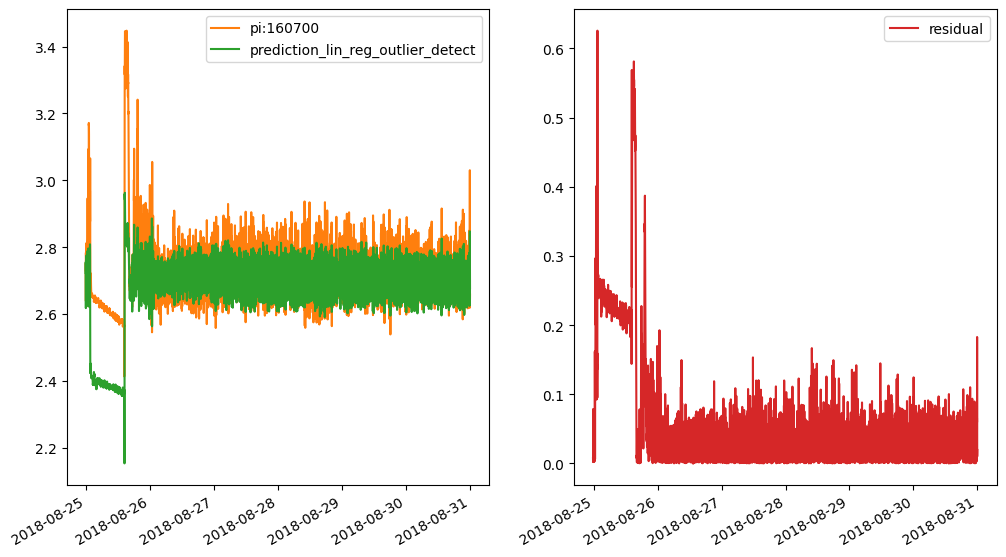

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
predict_df_ad.plot(
    y=[out_ts_name, "prediction_lin_reg_outlier_detect"],
    figsize=(12, 7),
    ax=ax1,
    color=["C1", "C2"],
)

predict_df_ad.plot(y=["residual"], figsize=(12, 7), ax=ax2, color="C3")

### Remarks
* We see a much larger error in our prediction in the period deemed anomalous. Setting a threshold for error of 0.2 seems like a reasonable approach for a simple model.
* This method could be used for a soft anomaly detection, but is reliant on an understanding of an SME when using the model